In [1]:
import numpy as np
from tqdm import tqdm
import os
import json
from torch.utils.data import Dataset, Sampler
import torch.utils.data as data

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets,models,transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import math
import os
import copy
import time
import sqlite3 as sql
import cv2
from tqdm import tqdm

/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


### Import model

In [2]:
## load model

confDict = torch.load("confidence_head_test0.pt")
dispDict = torch.load("disp_head_test0.pt")



In [3]:
MLP_KERNEL_SIZE = 1
MLP_FILTERS_1 = 256
MLP_FILTERS_2 = 64
CONTRACTION_RATIO = 2
PADDING_METHOD = 'same'
UPSAMPLE_MODE = 'nearest'
N_FEATURE_EXTRACTED = 8576
N_CLASSES = 17
SEQUENCE_SIZE = 112
BATCH_SIZE = 20
BATCH_PER_EPOCH = 1000

In [4]:
class MLP2(nn.Module):
    def __init__(self,n_features):
        super(MLP2,self).__init__()
        self.conv1 = nn.Conv1d(n_features,MLP_FILTERS_1,MLP_KERNEL_SIZE)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(MLP_FILTERS_1,MLP_FILTERS_2,MLP_KERNEL_SIZE)

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return out


In [5]:
class BottleneckResBlockContract(nn.Module):
    # Takes as input a feature matrix of size:
    #  _____
    # |     |
    # |     |
    # |     |
    # |     | T
    # |     |
    # |_____|
    #    P
    # Performs a bottleneck Resnetblock:
    # BN -> ReLU -> conv(1,P) ->BN ->ReLU -> conv(3,P) -> BN -> ReLU -> conv(1,2P) -> + -> output (of size T,2P)
    # |                                                                               ^
    # L>    ->  ->  ->  ->  ->  ->  ->  -> conv(1,2P) ->  ->  ->  ->    ->  ->  ->  ->|  
    def __init__(self,in_features):
        super(BottleneckResBlockContract,self).__init__()
        self.bn1 = nn.BatchNorm1d(in_features)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_features,in_features,1)
        self.bn2 = nn.BatchNorm1d(in_features)
        self.conv2 = nn.Conv1d(in_features,in_features,3,padding=PADDING_METHOD)
        self.bn3 = nn.BatchNorm1d(in_features)
        self.conv3 = nn.Conv1d(in_features,in_features*CONTRACTION_RATIO,1)
        self.conv_skip = nn.Conv1d(in_features,in_features*CONTRACTION_RATIO,1)

    def forward(self,x):
        y = self.bn1(x)
        y = self.relu(y)
        y = self.conv1(y)
        y = self.bn2(y)
        y = self.relu(y)
        y = self.conv2(y)
        y = self.bn3(y)
        y = self.relu(y)
        y = self.conv3(y)
        z = self.conv_skip(x)
        return y+z
    
class BottleneckResBlockExpand(nn.Module):
    # Takes as input a feature matrix of size:
    #  _____
    # |     |
    # |     |
    # |     |
    # |     | T
    # |     |
    # |_____|
    #    P
    # Performs a bottleneck Resnetblock:
    # BN -> ReLU -> conv(1,P/2) ->BN ->ReLU -> conv(3,P/2) -> BN -> ReLU -> conv(1,P/2) -> + -> output (of size T,P/2)
    # |                                                                               ^
    # L>    ->  ->  ->  ->  ->  ->  ->  -> conv(1,P/2) ->  ->  ->  ->    ->  ->  ->  ->|  
    def __init__(self,in_features):
        in_features = int(in_features)
        super(BottleneckResBlockExpand,self).__init__()
        self.bn1 = nn.BatchNorm1d(int(in_features))
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_features,int(in_features/CONTRACTION_RATIO),1)
        self.bn2 = nn.BatchNorm1d(int(in_features/CONTRACTION_RATIO))
        self.conv2 = nn.Conv1d(int(in_features/CONTRACTION_RATIO),int(in_features/CONTRACTION_RATIO),3,padding=PADDING_METHOD)
        self.bn3 = nn.BatchNorm1d(int(in_features/CONTRACTION_RATIO))
        self.conv3 = nn.Conv1d(int(in_features/CONTRACTION_RATIO),int(in_features/CONTRACTION_RATIO),1)
        self.conv_skip = nn.Conv1d(in_features,int(in_features/CONTRACTION_RATIO),1)

    def forward(self,x):
        y = self.bn1(x)
        y = self.relu(y)
        y = self.conv1(y)
        y = self.bn2(y)
        y = self.relu(y)
        y = self.conv2(y)
        y = self.bn3(y)
        y = self.relu(y)
        y = self.conv3(y)
        z = self.conv_skip(x)
        return y+z

class UpsamplingBlock(nn.Module):
# Takes as input a feature matrix of size (with ncol: nFeatures and nrow: nTimePoints) :
    #  _____
    # |     |
    # |     |
    # |     |
    # |     | T
    # |     |
    # |_____|
    #    P
# Upsample uses nearest neighbor to output a 2TxP matrix
# a Conv(2,P/2) is then applied with padding = same
    
    def __init__(self,in_feature):
        super(UpsamplingBlock,self).__init__()
        in_feature = int(in_feature)
        self.upsample = nn.Upsample(scale_factor=2,mode=UPSAMPLE_MODE)
        self.conv = nn.Conv1d(in_feature, int(in_feature/2),kernel_size=2, padding=PADDING_METHOD)
    
    def forward(self,x):
        out = self.upsample(x)
        out = self.conv(out)
        return out
    

class Unet1D(nn.Module):
    def __init__(self,in_feature):
        super(Unet1D,self).__init__()

        #LEFT PART
        self.maxpool = nn.MaxPool1d(2)

        self.contr1 = BottleneckResBlockContract(in_feature)
        #self.maxpool
        nb_f = in_feature*2
        self.contr2 = BottleneckResBlockContract(nb_f)
        #self.maxpool
        nb_f = nb_f*2
        self.contr3 = BottleneckResBlockContract(nb_f)
        #self.maxpool
        nb_f = nb_f*2
        #self.contr4 = BottleneckResBlockContract(nb_f)
        #self.maxpool
        #nb_f = nb_f*2
        ##############################################

        #DOWN PART
        
        self.contr5 = BottleneckResBlockContract(nb_f)
        nb_f = nb_f*2
        ##############################################

        #RIGHT PART

        #self.upsample4 = UpsamplingBlock(nb_f)
        #nb_f = nb_f/2
        #concat
        #nb_f = nb_f*2
        #self.expand4 = BottleneckResBlockExpand(nb_f)
        #nb_f = nb_f/2

        self.upsample3 = UpsamplingBlock(nb_f)
        nb_f = nb_f/2
        #concat
        nb_f = nb_f*2
        self.expand3 = BottleneckResBlockExpand(nb_f)
        nb_f = nb_f/2

        self.upsample2 = UpsamplingBlock(nb_f)
        nb_f = nb_f/2
        #concat
        nb_f = nb_f*2
        self.expand2 = BottleneckResBlockExpand(nb_f)
        nb_f = nb_f/2

        self.upsample1 = UpsamplingBlock(nb_f)
        nb_f = nb_f/2
        #concat
        nb_f = nb_f*2
        self.expand1 = BottleneckResBlockExpand(nb_f)
        nb_f = nb_f/2

        self.upsample0 = UpsamplingBlock(nb_f)
        nb_f = nb_f/2
        #concat
        nb_f = nb_f*2
        self.expand0 = BottleneckResBlockExpand(nb_f)
        nb_f = nb_f/2

    def forward(self,x):
        # X is of shape [nbatch,64,224]

        # LEFT PART
        l0 = x #[P,T]           #Output shape
        a = self.maxpool(l0)    #[P,T/2]
        l1 = self.contr1(a)     #[P*2,T/2]
        b = self.maxpool(l1)    #[P*2,T/4]
        l2 = self.contr2(b)     #[P*4,T/4]
        c = self.maxpool(l2)    #[P*4,T/8]
        l3 = self.contr3(c)     #[P*8,T/8]
        d = self.maxpool(l3)    #[P*8,T/16]
        #l4 = self.contr4(d)     #[P*16,T/16]
        #e = self.maxpool(l4)    #[P*16, T/32]

        # DOWN PART
        l5 = self.contr5(d)     #[P*32,T/32]

        # RIGHT PART
        #r4 = self.upsample4(l5)     #[P*16,T/16]
        #t4 = torch.cat((l4,r4),1)   #[P*32,T/16]
        #t4 = self.expand4(t4)       #[P*16,T/16]
        r3 = self.upsample3(l5)     #[P*8,T/8]
        t3 = torch.cat((l3,r3),1)   #[P*16,T/8]
        t3 = self.expand3(t3)       #[P*8,T/8]
        r2 = self.upsample2(t3)     #[P*4,T/4]
        t2 = torch.cat((l2,r2),1)   #[P*8,T/4]
        t2 = self.expand2(t2)       #[P*4,T/4]
        r1 = self.upsample1(t2)     #[P*2,T/2]
        t1 = torch.cat((l1,r1),1)   #[P*4,T/2]
        t1 = self.expand1(t1)       #[P*2,T/2]
        r0 = self.upsample0(t1)     #[P,T]
        t0 = torch.concat((l0,r0),1)#[P*2,T]
        t0 = self.expand0(t0)       #[P,T]

        return t0 # P features, T points

In [6]:
class PredictionHead(nn.Sequential):
    def __init__(self,n_features):
        super(PredictionHead,self).__init__()
        self.mlp = MLP2(n_features)
        self.unet = Unet1D(MLP_FILTERS_2)
        self.convHead = nn.Conv1d(MLP_FILTERS_2,N_CLASSES,kernel_size=3,padding=PADDING_METHOD)


In [7]:
class TemporalHead(nn.Sequential):
    def __init__(self,n_features):
        super(TemporalHead,self).__init__()   
        self.mlp = MLP2(n_features)
        self.unet = Unet1D(MLP_FILTERS_2)
        self.convHead = nn.Conv1d(MLP_FILTERS_2,N_CLASSES,kernel_size=3,padding=PADDING_METHOD)


In [8]:
modelConf = PredictionHead(N_FEATURE_EXTRACTED)
modelDisp = TemporalHead(N_FEATURE_EXTRACTED)

### Get data

In [9]:
features =[]
labels = []
timeLabel = []

path = '/scratch/users/mdelabrassinne/Database/'


for root, dirs, files in tqdm(os.walk(path)):
    #print(files)
    for file in files:
            
        if file.endswith("Labels-v2.json"):
            
            p = os.path.dirname(os.path.join(root, file))
            dire = os.path.basename(p).replace('_', ' ')
            p = os.path.join(os.path.dirname(p), dire)
            
            for r, d, fs in os.walk(p):
                for f in fs:
                    if f.endswith("baidu_soccer_embeddings.npy"):
                        p_current = os.path.join(r, f)
                        features.append(p_current)
                        #print(p_current)

            
            jsonPath =(os.path.join(root, file))
            #print(jsonPath)
            f = open(jsonPath)
            d = json.load(f)
            #print(d)
            
            #print(jsonPath)
            
            try:
                #print('test')
                lab = [d['annotations'][i]['label'] for i in range(len(d['annotations'])) if d['annotations'][i]['gameTime'][0] ==  '1']         # 1fps, don't know if keep 
                time = [60 * int(d['annotations'][i]['gameTime'].split(':')[0][-2:]) + int(d['annotations'][i]['gameTime'].split(':')[1][:2]) for i in range(len(d['annotations'])) if d['annotations'][i]['gameTime'][0] ==  '1']
                #print([d['annotations'][i]['gameTime'] for i in range(len(d['annotations']))])
                
                #print(time)
                
                labels.append(lab)
                timeLabel.append(time)
                
                lab = [d['annotations'][i]['label'] for i in range(len(d['annotations'])) if d['annotations'][i]['gameTime'][0] ==  '2']         # 1fps, don't know if keep 
                time = [60 * int(d['annotations'][i]['gameTime'].split(':')[0][-2:]) + int(d['annotations'][i]['gameTime'].split(':')[1][:2]) for i in range(len(d['annotations'])) if d['annotations'][i]['gameTime'][0] ==  '2']
                
                #print(time)
                labels.append(lab)
                timeLabel.append(time)
                
            except:
                #print(d)
                lab = [d['predictions'][i]['label'] for i in range(len(d['predictions'])) if d['predictions'][i]['gameTime'][0] == '1']         # 1fps, don't know if keep 
                time = [60 * int(d['predictions'][i]['gameTime'].split(':')[0][-2:]) + int(d['predictions'][i]['gameTime'].split(':')[1][:2]) for i in range(len(d['predictions'])) if d['predictions'][i]['gameTime'][0] == '1']
                
                labels.append(lab)
                timeLabel.append(time)
                
                lab = [d['predictions'][i]['label'] for i in range(len(d['predictions'])) if d['predictions'][i]['gameTime'][0] == '2']         # 1fps, don't know if keep 
                time = [60 * int(d['predictions'][i]['gameTime'].split(':')[0][-2:]) + int(d['predictions'][i]['gameTime'].split(':')[1][:2]) for i in range(len(d['predictions'])) if d['predictions'][i]['gameTime'][0] == '2']
                
                labels.append(lab)
                timeLabel.append(time)
            

            
data_l = list(zip(features, labels, timeLabel))

98714it [05:09, 318.52it/s]


### Get the wanted sequence

In [10]:
## Select the match
features, labels, timeLabel = data_l[0]


## choose index that correspond to the wanted output
cL = ['Kick-off', 'Ball out of play', 'Throw-in', 'Foul', 'Clearance', 'Indirect free-kick', 'Shots on target', 'Corner', 'Shots off target', 'Direct free-kick', 'Yellow card', 'Substitution', 'Red card', 'Offside', 'Goal', 'Penalty', 'Yellow->red card']
nbClasse = 0   # class that is looked for
print(f"looking for => {cL[nbClasse]}")
lengthSequence = 112

features = np.load(features)


nbList = 1 # which element of the list


index_array = np.core.defchararray.find(np.array(labels), cL[nbClasse])   # find where the label is represented
timeCode = np.array(timeLabel)[index_array >= 0]                          # find the associated timecodes in the match

selected_frame = timeCode[nbList]
if(selected_frame > lengthSequence and selected_frame < features.shape[0]-lengthSequence):
    frameMin = int(selected_frame - (lengthSequence/2))
    frameMax = int(selected_frame + (lengthSequence/2))
    selected_sequence = features[frameMin:frameMax, :]
    print(selected_sequence.shape)


looking for => Kick-off
(112, 8576)


### Analyze it

In [11]:
def plotConfMatrix(mat, x = None, y = None, cmap = 'RdBu'):
    
    ## check if x or y are None
    
    if x is None:
        x = np.arange(0, mat.shape[0])
        
    if y is None:
        y = np.arange(0, mat.shape[1])
        
    
    fig = plt.figure()
    ax = plt.axes()
    qm =ax.pcolormesh(x, y, mat.T, cmap=cmap, vmin = 0, vmax = 1)
    plt.colorbar(qm)
    ax.set_xlabel('Class')
    ax.set_ylabel('Time')
    ax.set_xticks(x)
    #ax.set_yticks(y + 0.5)
    ax.set_xticklabels(cL, rotation=90)
    plt.show()
    
def plotDispMatrix(mat, x = None, y = None, cmap = 'RdBu'):
    
    ## check if x or y are None
    
    if x is None:
        x = np.arange(0, mat.shape[0])
        
    if y is None:
        y = np.arange(0, mat.shape[1])
        
    fig = plt.figure()
    ax = plt.axes()
    qm = ax.pcolormesh(x, y, mat.T, cmap=cmap)
    plt.colorbar(qm)
    ax.set_xlabel('Class')
    ax.set_ylabel('Time')
    ax.set_xticks(x)
    #ax.set_yticks(y + 0.5)
    ax.set_xticklabels(cL, rotation=90)
    plt.show()

/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


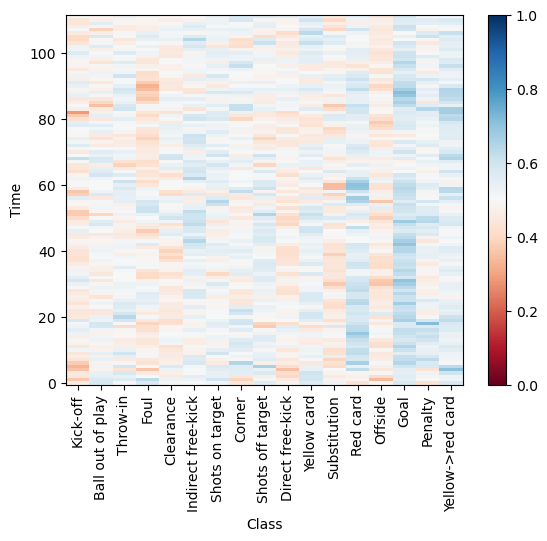

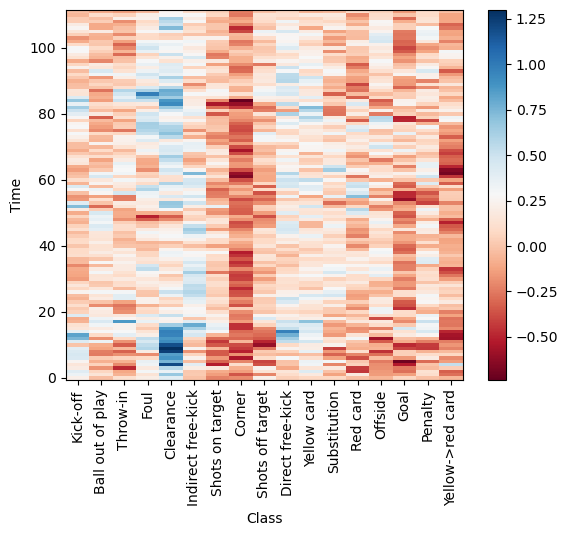

In [12]:
seq = torch.from_numpy(selected_sequence)

seq = seq.reshape(1, lengthSequence, 8576).transpose(1,2)

#print(torch.sigmoid(modelConf(seq).detach()[0, :, :]))

confResult = torch.sigmoid(modelConf(seq).detach()).numpy()
confDisp = modelDisp(seq).detach().numpy()

plotConfMatrix(confResult[0,:,:])
plotDispMatrix(confDisp[0, :, :])

In [13]:
np.arange(0,3)

array([0, 1, 2])

### V2: Compare with the ground truth

In [14]:
cL = ['Kick-off', 'Ball out of play', 'Throw-in', 'Foul', 'Clearance', 'Indirect free-kick', 'Shots on target', 'Corner', 'Shots off target', 'Direct free-kick', 'Yellow card', 'Substitution', 'Red card', 'Offside', 'Goal', 'Penalty', 'Yellow->red card']

def getTrueCoef(label, timeCodes, T, nbClasses, r_c = 3, f = 1, r_d = 6):
    C = []      #confidence as a 2D np array instead of a list of tupes

    ## Init
    res_conf = np.zeros((T, nbClasses))         # initialization of the output C
    res_disp = np.zeros((T, nbClasses))         # initialization of the output D
    domain_disp = np.zeros((T, nbClasses))      # initialization of the domain for D ==> the domain has 1 when the value has to be computed for the loss on the displacement and 0 otherwise
    
    dictClasses = {}    # dictionnary containing the list wiht the timecodes of the actions for a given class

    ## Init of the dictionnary
    for c in range(nbClasses):
        dictClasses[c] = []

    ## Focus on the confidence part
    for i in range(len(timeCodes)):        #loop over obtained labels
        t = timeCodes[i]
        c = label[i]
        
        if(c in cL):                           # focus on wanted classes
            c = cL.index(label[i])

            # get the interval on which C contains 1 for a given class
            tmin = max(0, t - r_c * f)        # cannot be lower than 0
            tmax = min(t + r_c * f, T-1)      # cannot be larger than T-1
            inds = np.arange(tmin, tmax+1)    # select the timecodes between tmin and tmax
            res_conf[inds, c] = 1             # put 1 in C at the good position
            
            ## Update the dictionnary
            dictClasses[c].append(t)
            
        ## test for bad cases (don't occur)
        if(t > T):
            print('\n\naie => t = {} -- T = {}\n\n'.format(t, T))
            
        if(i >= 2700):
            print("possible issue ")
            
            
    ## Focus on the displacement part
    for c in range(nbClasses):
        ind = np.array(dictClasses[c])       # find the list of timecodes for a given action
        
        if(len(ind) > 0):
            for t in range(T):           # go through all frames

                ## Find the frame containing an occurence which is the closest (and get the corresponding index)
                try:
                    closestInd = np.argmin(np.abs(ind - t))         #take the one that is the most on the left if draw
                except:
                    print(ind)
                    print(t)
                    print(len(ind))

                ## Check if in the domain
                if(np.abs(t - ind[closestInd]) <= r_d * f):
                    res_disp[t, c] = t - ind[closestInd]      # put the displacement in the matrix
                    domain_disp[t, c] = 1                     # keep the value in the domain
            
        
    return res_conf, res_disp, domain_disp

#test_C, test_D, dom = getTrueCoef(data_l[0][1],data_l[0][2], np.load(data_l[0][0]).shape[0], len(cL) )


In [15]:
gr_conf, gr_disp, _ = getTrueCoef(labels, timeLabel, features.shape[0], len(cL))
print(gr_conf.shape)

(2700, 17)


In [16]:
## Select the match
features, labels, timeLabel = data_l[0]


## choose index that correspond to the wanted output
cL = ['Kick-off', 'Ball out of play', 'Throw-in', 'Foul', 'Clearance', 'Indirect free-kick', 'Shots on target', 'Corner', 'Shots off target', 'Direct free-kick', 'Yellow card', 'Substitution', 'Red card', 'Offside', 'Goal', 'Penalty', 'Yellow->red card']
nbClasse = 0   # class that is looked for
print(f"looking for => {cL[nbClasse]}")
lengthSequence = 112

features = np.load(features)


nbList = 1 # which element of the list


index_array = np.core.defchararray.find(np.array(labels), cL[nbClasse])   # find where the label is represented
timeCode = np.array(timeLabel)[index_array >= 0]                          # find the associated timecodes in the match

selected_frame = timeCode[nbList]
if(selected_frame > lengthSequence and selected_frame < features.shape[0]-lengthSequence):
    frameMin= int(selected_frame - (lengthSequence/2))
    frameMax = int(selected_frame + (lengthSequence/2))
    selected_sequence = features[frameMin:frameMax, :]
    groundTruth_conf = gr_conf[frameMin:frameMax, :]
    groundTruth_disp = gr_disp[frameMin:frameMax, :]
    print(selected_sequence.shape)


looking for => Kick-off
(112, 8576)


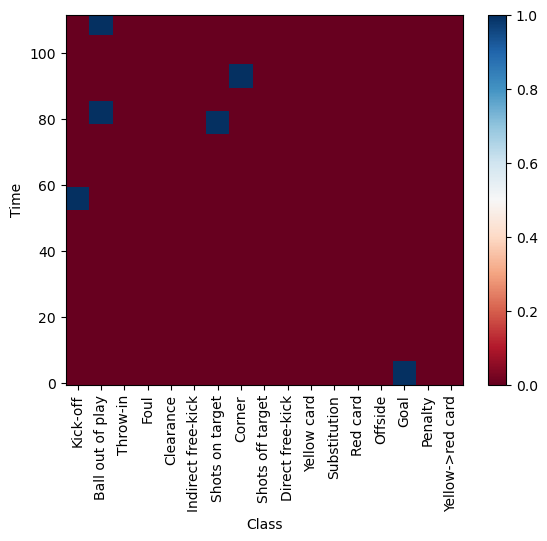

In [17]:
plotDispMatrix(groundTruth_conf.T)

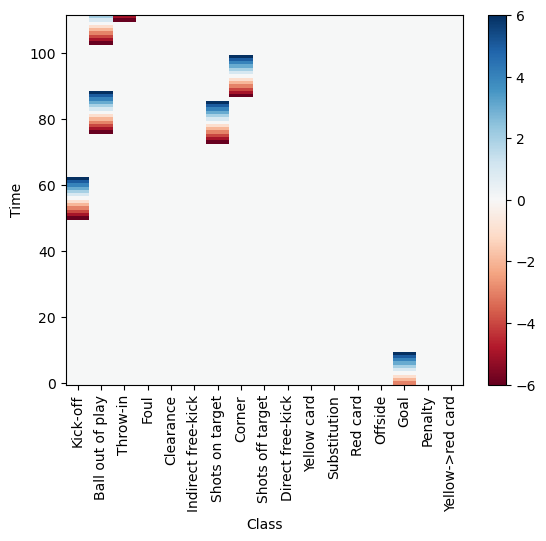

In [18]:
plotDispMatrix(groundTruth_disp.T)

In [23]:
def createGlobalFigure(mat_conf, mat_disp, gtruth_conf, gtruth_disp, cmap='RdBu', figsize=(10, 8)):
    fig, axes = plt.subplots(2, 2, figsize = figsize)

    x = np.arange(0, mat_conf.shape[0])
    y = np.arange(0, mat_conf.shape[1])

    qm = axes[0, 0].pcolormesh(x, y, mat_conf.T, cmap=cmap, vmin = 0, vmax =1)
    fig.colorbar(qm, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Time')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(cL, rotation=90)

    x = np.arange(0, gtruth_conf.shape[0])
    y = np.arange(0, gtruth_conf.shape[1])

    qm = axes[0, 1].pcolormesh(x, y, gtruth_conf.T, cmap=cmap, vmin = 0, vmax =1)
    fig.colorbar(qm, ax=axes[0, 1])
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('Time')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(cL, rotation=90)

    x = np.arange(0, mat_disp.shape[0])
    y = np.arange(0, mat_disp.shape[1])

    qm = axes[1, 0].pcolormesh(x, y, mat_disp.T, cmap=cmap, vmin = -6, vmax = 6)
    fig.colorbar(qm, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Time')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(cL, rotation=90)

    x = np.arange(0, gtruth_disp.shape[0])
    y = np.arange(0, gtruth_disp.shape[1])

    qm = axes[1, 1].pcolormesh(x, y, gtruth_disp.T, cmap=cmap, vmin = -6, vmax = 6)
    fig.colorbar(qm, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Time')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(cL, rotation=90)
    
    fig.tight_layout()
    plt.savefig("pred_vs_ground_truth.pdf")

    plt.show()


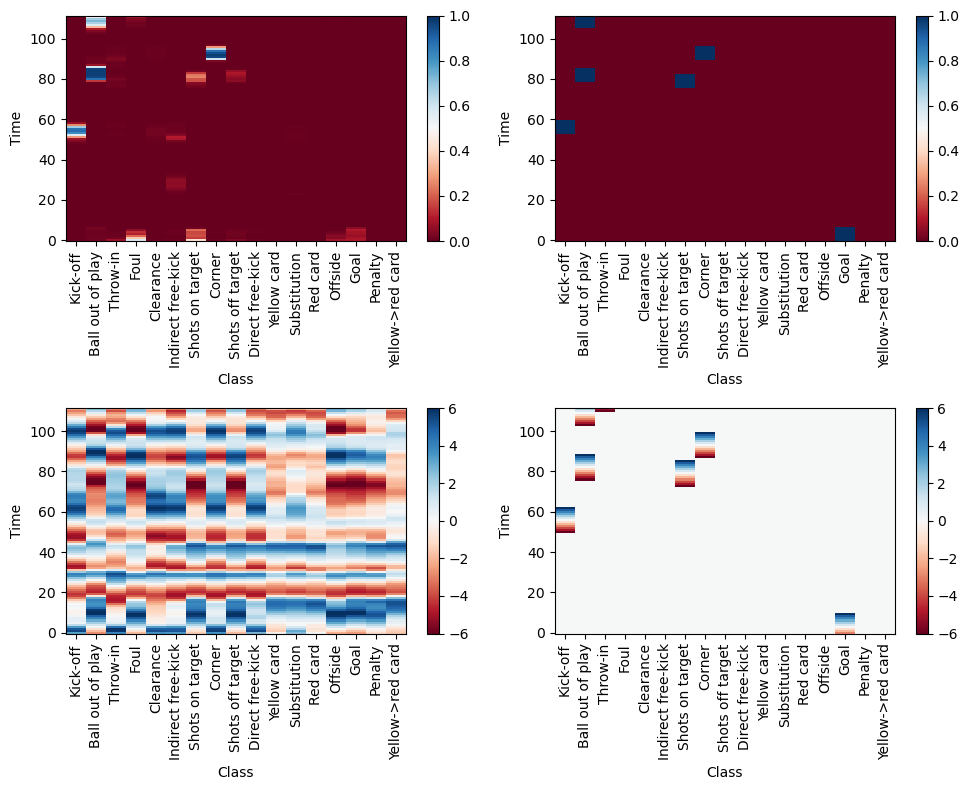

In [24]:
seq = torch.from_numpy(selected_sequence)
modelConf = PredictionHead(N_FEATURE_EXTRACTED)
modelConf.load_state_dict(torch.load('confidence_head_test0_base.pt'))
modelDisp = TemporalHead(N_FEATURE_EXTRACTED)
modelDisp.load_state_dict(torch.load('disp_head_test0.pt'))

seq = seq.reshape(1, lengthSequence, 8576).transpose(1,2)

confResult = torch.sigmoid(modelConf(seq).detach()).numpy()
confDisp = modelDisp(seq).detach().numpy()

createGlobalFigure(confResult[0, :, :], confDisp[0, :, :],groundTruth_conf.T, groundTruth_disp.T)